# Merge Trees of Point Clouds


In [1]:
import sys
sys.path.insert(0, './Trees')

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import manifold

from DMT_tools import *

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

from Utils_dendrograms_OPT import dendrolink, prune_dendro, from_cloud_to_dendro_sublvl,\
                                  prune_dendro_N

from Interleaving_distance import interleaving,interl_approx, dist_wrap

import persim
import ripser

In [3]:
def prune_aux(T,G,N=100,max_leaves=15,p=1):

    grid = np.linspace(0,1,N)
    eps = grid**p
    
    if (len(T.leaves)<=max_leaves or len(G.leaves)<=max_leaves):
        eps = [0]
    else:
        M = np.max([T.f_uniq[-1]-T.f_uniq[0],G.f_uniq[-1]-G.f_uniq[0]])
        eps = eps*M
        
    thresh = eps[0]
    d = 0
    cnt = -1
    
    T_aux = prune_dendro(T,thresh,keep_root=False)
    G_aux = prune_dendro(G,thresh,keep_root=False)
    
    tmp_T = 0
    tmp_G = 0
    
    while cnt+1<len(eps) and (len(T_aux.leaves)>max_leaves or len(G_aux.leaves)>max_leaves):
        cnt+=1
        thresh = eps[cnt] 
        
        T_aux = prune_dendro(T_aux,thresh,keep_root=False)
        G_aux = prune_dendro(G_aux,thresh,keep_root=False)      
        
    idx = cnt
    thresh = eps[idx]

    return [T_aux, G_aux], thresh/2

In [4]:

def killtree(p, including_parent=True):
    pid = p.pid
    parent = psutil.Process(pid)
    for child in parent.children(recursive=True):
#         print("child", child)
        child.kill()

    if including_parent:
        parent.kill()

In [6]:
import time
import multiprocessing
import psutil

npts = 0
N = 100
loc = 5
np.random.seed(1062022)
MP = True
verbose = True
K = 15
mesh = 100 # parameter from Curry

#APPROX = 'low' #computes lower bound
APPROX = 'upper' #computes upper bound

CHECK = []
EXAMPLES = []

a=100

TIMES = []

for npts in (list(np.arange(3,15))+list(np.arange(100,110))):
    
    print('\n')
    
    err = []
    err_n = []
    discr_n = []
    tmp = 0
    
    while tmp<N:
        
        TREES = []
        MT = []
        PDs = []
        pr_errors = []
        for _ in range(2):
            sig0 = np.abs(np.random.normal(3,1,1))
            sig1 = np.abs(np.random.normal(3,1,1))
            c = 100*np.array([np.random.normal(loc,sig0,npts),\
                          np.random.normal(loc,sig1,npts)]).T        

            m = squareform(pdist(c))
            T = dendrolink(m,linkage='single')
            T.make_mult(f=False)
            T.make_norms_mult()
            TREES.append(T)

            MT_i = MergeTree(pointCloud = c)
            MT.append(MT_i)
            
            dgm = ripser.ripser(c)['dgms'][1]
            PDs.append(dgm)
            
            
        t0 = time.time()   

        d_app = merge_tree_interleaving_distance(MT[0],MT[1],mesh,verbose = False)

        t1 = time.time()  

        TREES_aux, eps = prune_aux(TREES[0], TREES[1], N=50, max_leaves=K) 

        if npts<a:
            
            t_aux_1 = time.time()  

            
            d_l = interleaving(TREES_aux[0], TREES_aux[1], binary=True,approx=APPROX, 
                                              MP=True, check=False,
                                              verbose = False)
            t_aux_2 = time.time()  
            
            
            if n_pts == 14:
                TIMES.append(t_aux_2-t_aux_1)
            
            
        else:
            d_l=0



        d_l_aux = persim.bottleneck(PDs[0], PDs[1], matching=False)

        d_l = np.max([d_l,d_l_aux])



        q = multiprocessing.Queue()
        p = multiprocessing.Process(target=dist_wrap, args=(TREES_aux,q,) )
        p.start()

        aux = np.min([npts,K])

        p.join(1000)
        
        if p.is_alive():                

            killtree(p)

        else:
            out = q.get()
#                 eps = out['eps']
            d = out['d']
            check = out['flag']        
            d_u = np.max([d,eps])

            p.terminate()

            CHECK.append(check)

            t2 = time.time()   

            if check == 0:
                EXAMPLES.append(TREES)

            delta_n =(d_app-d_u)/d_u
            delta = (d_app-d_u)
            discr = (d_u-d_l)/d_u

            err_n.append(delta_n)
            err.append(delta)
            discr_n.append(discr)

            if tmp == 0 or delta<0:
                print('\nNumber of initial leaves: ', npts)
                print(' Optimiz Distance: ', d,'Time: ',t2-t1,'Pruning Error: ',eps) 
                print(' Labeled Distance: ', d_app,'Time: ',t1-t0)
            else:
                print(tmp, end='\r')

            tmp = len(err)

        print('npts e tmp: ', npts,tmp-1,
          'n_leaves: ',len(TREES_aux[0].leaves),len(TREES_aux[1].leaves),
          'distances: ',d_u,d_l,d_app,
          '                     ',end='\r')

    ERR_n = np.array(err_n)
    ERR = np.array(err)
    DISCR=np.array(discr_n)


    np.save('ERR_'+str(a)+'_'+str(npts),ERR)
    np.save('ERR_n_'+str(a)+'_'+str(npts),ERR_n)
    np.save('DISCR_'+str(a)+'_'+str(npts),DISCR)



Number of initial leaves:  3
 Optimiz Distance:  162.19907494125533 Time:  7.354478120803833 Pruning Error:  0.0
 Labeled Distance:  162.19907494125533 Time:  0.0026607513427734375
npts e tmp:  3 99 n_leaves:  3 3 distances:  94.0621763933371 94.06217639333744 130.19379020987805                         
Number of initial leaves:  4
 Optimiz Distance:  408.874934494744 Time:  10.642385244369507 Pruning Error:  0.0
 Labeled Distance:  564.7636438224323 Time:  0.005645751953125
npts e tmp:  4 99 n_leaves:  4 4 distances:  439.9215780006872 439.9215780006872 466.6680514993265                         
Number of initial leaves:  5
 Optimiz Distance:  251.4798060519276 Time:  13.485979080200195 Pruning Error:  0.0
 Labeled Distance:  251.4798060519276 Time:  0.0033118724822998047
npts e tmp:  5 99 n_leaves:  5 5 distances:  284.5382676893924 284.5382676893924 455.71820804698353                        
Number of initial leaves:  6
 Optimiz Distance:  138.27303433418274 Time:  12.4132928848266

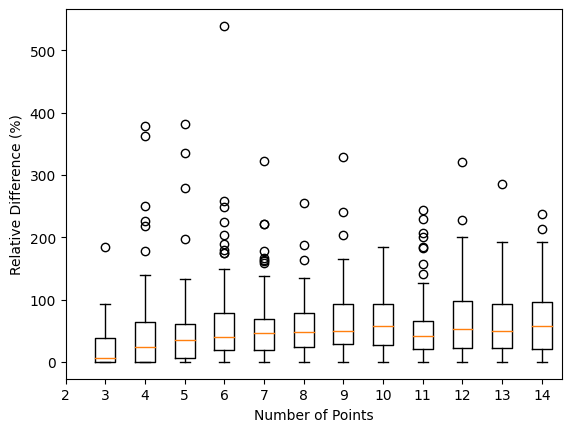

In [8]:
ERR_n = []
m_ERR = []
m_ERR_n = []
max_ERR_n = []

K=100

for npts in np.arange(3,15):
    ERR_n.append(np.load('ERR_n_'+str(a)+'_'+str(npts)+'.npy')*K)

    m_ERR_n.append(np.mean(ERR_n))
    max_ERR_n.append(np.max(ERR_n))
    
plt.boxplot(ERR_n)
plt.xticks(np.arange(0,len(ERR_n)+1), np.arange(2,15))
plt.xlabel('Number of Points')
plt.ylabel('Relative Difference (%)')
#plt.legend()

ERR_n = np.array(ERR_n)
m_ERR_n = np.array(m_ERR_n)
max_ERR_n = np.array(max_ERR_n)

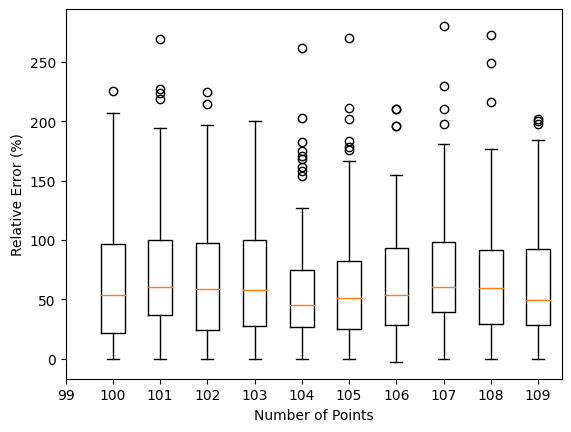

In [10]:
ERR_n = []
m_ERR = []
m_ERR_n = []
max_ERR_n = []

K=100

for npts in np.arange(100,110):
    ERR_n.append(np.load('ERR_n_'+str(a)+'_'+str(npts)+'.npy')*K)

    m_ERR_n.append(np.mean(ERR_n))
    max_ERR_n.append(np.max(ERR_n))
    
plt.boxplot(ERR_n)
plt.xticks(np.arange(0,len(ERR_n)+1), np.arange(99,110))
plt.xlabel('Number of Points')
plt.ylabel('Relative Error (%)')

ERR_n = np.array(ERR_n)
m_ERR_n = np.array(m_ERR_n)
max_ERR_n = np.array(max_ERR_n)